# Predicting League of Legends Match Outcome at Different Times of the Game

## Introduction

League of Legends (LoL) is a popular online game developed and published by Riot Games. It is known to be among the most popular online games ever created, with over 180 million active players to date. In LoL, each team has five players, and each player controls a chosen in-game character, each character with their own unique quirks and abilities; these characters are referred to as "champions." The objective of each team is centered around one main goal: destroy the enemy team's Nexus by any means necessary. Generally speaking, players of a team must work together to disarm the enemy's defense by killing opposing players, which allow them to destroy buildings of the enemy's base, bringing them closer to the Nexus. Of course, it's not quite that simple, as there are many other aspects of the game which buffs one's champion, makes it easier for players to kill or harder to be killed. 
    
|<img src="sum-rift.jpeg" width="600"> | 
|:--:| 
| *This is a map of Summoner's Rift, the most commonly played map in LoL and the map we'll be focusing on for our analysis. You can see the top right and bottom left corners contain the Nexus's for each team (Red and Blue), and all the towers and other structures in each of the lanes that consist of each team's base.* |

There are two primary methods to improving one's champion: leveling up by gathering experience and purchasing items using gold. Players gain experience from killing game entities, ranging from enemy minions and champions to neutral monsters. Accumulating experience levels up champions which improves their base stats and abilities, so generally the more experience - and therefore levels - a player has, the stronger their base abilities are. However, these stats can also be further augmented by purchasing items from the shop using gold. The effects of items range from increasing certain stats (health, mana, armor, attack damage, etc.) to giving players special abilities which can provide benefits both in and out of combat. Since items require gold to purchase, gold is naturally one of the most valuable resources in the game. Gold is mostly earned through killing the same game entities that grant experience in addition to enemy structures such as turrets.

Our goal for this tutorial is to be able to generate a model for a particular player that learns from their data in previous games at fixed time intervals. This model should then be able to provide a prediction for an ongoing game's outcome given player-known information during the game at those same time intervals. Players only have limited knowledge of both teams during a game such as the enemy players' items (which can be used to estimate their total gold), the kills and deaths of each team, and the state of objectives in the game such as structures or elite monsters that can give powerful team-wide stat boosts. As such, the particular player should be able to input their ongoing game's information into the model and receive a prediction as to how likely it is that they will win the game.

One question is why not just look at large amounts of game data all at once, either from across many players or from one singular player or group of players? In order to answer this, one must have a light understanding of the ranking system in LoL. There are 9 tiers in the LoL ranking system, ranging from Iron at the bottom, then Silver, Gold, etc., all the way up to Challenger at the top. These ranks stratify players into skill levels, with the lower 50% of players residing in the bottom three tiers, and the top 50% in the upper 6 with decreasing percentages the higher the tier. It's important to realize that different ranks result in very different skills, playstyles, and amounts of coordination in each game. A game of Bronze players is almost guaranteed to run very different compared to a game of Challenger players even if all the chosen champions are the same, simply because the players themselves are very different in terms of mechanical skills and game knowledge. As a result, if we were to generate a model based on game data across all the ranks, our model would essentially be ignoring these rank differences and generalizing to all players, which is bound to run into much more inaccuracy. On the other hand, if we trained a model based on data from a particular rank, it might be effective for that rank and neighboring ranks, but the further away the rank, the less applicable the model will be.

To solve this, we could generate a model for each rank, but that would be much more costly and time consuming. Instead, we decided to make the model more personalized, sacrificing the ability to retrieve large amounts of tangentially related data in order to train on a smaller amount of highly relevant data - the particular player's own match history. This allows the player to have a customized model for themselves without any bias or noise from other players that may have vastly different playstyles.

In this tutorial, we'll show you how to collect the necessary data, how we analyzed our data to determine which variables are important for creating our model, the creation of the model itself, and how to utilize the model in order to predict the outcome of ongoing games.

## Data Collection

Let's begin by importing the necessary packages for our data collection and analysis.

In [1]:
import os
import time

# Data Manipulation and Visualization
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Request
import requests

In order to use the Riot API, you need an account to generate an API key. If you already have a Riot account, you simply need to log in and generate a key [here](https://developer.riotgames.com/).

In [27]:
api_key = "Enter your API key here!"

### Collect Match IDs

In order to do perform our analysis, we first needed to collect our desired data. To do this, we created a Riot account to interact with the League of Legends API, from which we retreived all the necessary data. We use the "requests" library to make GET requests to the Riot API. 

You can choose any LoL player you want to run this project on by using their username. For this project, we chose to do it on player "HULKSMATH1337." So, we began by getting the player ID of "HULKSMASH1337," the player's games we wanted to analyze, then used their player ID to retrieve the match IDs of that player in the two months before December 15, 2021 (this is the day we collected our data). We complied these IDs into a list in preparation for the next step.

In [3]:
username = "hulksmash1337" # Enter a username of your choosing!

# This is about 2 months ago from Dec 15, 2021
start_time = 1634327826
week_in_seconds = (24 * 3600) * 7

# Get the puuid (player ID) from username
puuid_URL = f"https://na1.api.riotgames.com/lol/summoner/v4/summoners/by-name/{username}?api_key={api_key}"
r = requests.get(url=puuid_URL)
data = r.json()
puuid = data["puuid"]

match_ids = []

# 8 for 8 weeks in 2 months
for i in range(8):
    start = start_time + i * week_in_seconds
    end = start_time + (i + 1) * week_in_seconds
    match_id_URL = f"https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?startTime={start}&endTime={end}&count=100&api_key={api_key}"
    match_id_r = requests.get(url=match_id_URL).json()
    match_ids = match_ids + match_id_r
    
# sort match IDs so they're sorted by time
match_ids = sorted(match_ids)


### Collect Match Data

For each match, there are two different types of data we can collect. One gives us high level information about the match, such as match outcome, total gold collected, and total experience collected. This data is stored in `matches_data`, and we need to collect this data solely for the purpose of determining the outcome of the game. Of course, since we're trying to predict the outcome of the game based on in-game data at a certain time into the game (at 7 mins, 13 mins, 18 mins), we also need to collect timeline data. The API provides this kind of data, where at each minute the current stats are recorded and saved. We save this data in `matches_timeline`.

Both `matches_data` and `matches_timeline` are lists which store these data, so for each API call we simply just append the retrieved data to the these lists.

For free users, the API imposes a limit of 100 calls per 2 minutes. Since we're making many calls to retrieve all the necessary data, we have to take this limit into account in our code. To get around this limit, we split the data into size 50 chunks, then run our data-retrieval code for that chunk which will require 100 calls or less. We ensure that these chunks are run once every 2 minutes.


The following is the function we used to retrieve the match data and append it to the lists, given the match ID. Notice that we only appended the data of matches that lasted 20 minutes or longer. We did this to ensure that we had access to match data at 18 minutes for all matches, which we of course wouldn't have if the game ended before 18 minutes.

In [4]:
# Appends match data to lists
def append_match_data(match_id):
    URL = f'https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}?api_key={api_key}'
    match_data = requests.get(url=URL).json()
    
    # If match was less than 15 mins long, we want nothing of it
    if match_data['info']['gameDuration'] < 60*20:
        return
        
    # Endpoint to get the timeline match data
    URL = f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}/timeline?api_key={api_key}"
    
    matches_timeline.append(requests.get(url=URL).json())
    matches_data.append(match_data)

In [9]:
# Running this resets the matches
matches_timeline = []
matches_data = []

for i in range(len(match_ids) // 50):
    start_time = time.time()
    
    # Get 50 length chunk of match IDs
    curr_match_ids = match_ids[i*50 : (i+1)*50]
    
    for match_id in curr_match_ids:
        append_match_data(match_id)
    
    end_time = time.time()
    
    time_elapsed = end_time - start_time
    
    time_to_wait = 125 - time_elapsed
    
    # Sleep the remaining amount necessary to reach 2 mins before making the next batch of calls
    time.sleep(max(0, time_to_wait))
    

### Data parsing functions

The following functions were written to help with parsing the necessary data from the large datasets for each match.

##### Function For Retrieving Gold Totals For Each Team in a Given Minute

Given a particular minute number and the game data, this function retrieves the total gold of each team in the provided minute during the match. This is done by extracting the frame matching the requested minute from the game data and then retrieving the data for each player, combining the total player gold for each player of each team in order to get a total for both teams. This gold information will be used to determine which team is most likely stronger in terms of items, which gives an idea of their bonus stats.

In [11]:
def get_gold(frame_num, match_r):
    
    match_frames = match_r['info']['frames']

    # Teamid 100: Participants 1 through 5
    # Teamid 200: Participants 6 through 10
    
    pgold = {}

    frame = match_frames[frame_num]
    participants = frame['participantFrames']
    
    for p_id in participants:
        participant = participants[p_id]
        pgold[p_id] = participant['totalGold']

    team100gold = sum([pgold[str(i)] for i in range(1,6)])
    team200gold = sum([pgold[str(i)] for i in range(6,11)])

    return {'100': team100gold, '200': team200gold}


##### Function For Retrieving Average Level of Each Team in a Given Minute

Given a particular minute number and the game data, this function retrieves the average level of each team in the provided minute during the match. This is done similarly to above, except retrieving the levels of each player and calculating the averages for each team. This level information will be used to determine which team is overall stronger in terms of levels, which gives an idea of their base stats.

In [12]:
def get_avg_levels(frame_num, match_r): 
    all_lvls = []

    # Teamid 100: Participants 1 through 5
    # Teamid 200: Participants 6 through 10
    team_1_lvl = 0
    team_2_lvl = 0
    
    for j in range(10):
        if j < 5:
            team_1_lvl = team_1_lvl + match_r["info"]["frames"][frame_num]["participantFrames"][str(j + 1)]["level"]
        else:
            team_2_lvl = team_2_lvl + match_r["info"]["frames"][frame_num]["participantFrames"][str(j + 1)]["level"]

    return {'100': team_1_lvl / 5, '200': team_2_lvl/5}

##### Function For Retrieving Elite Monster Events Up Until a Given Minute

Given a particular minute number and the game data, this function retrieves all the instances of an elite monster being killed up until the provided minute during the match. This is done by retrieving all in-game events, and selecting those that represent elite monster kills before the provided minute. Elite monsters are those that give powerful team-wide stat boosts upon being killed, giving the team responsible for slaying them a powerful edge against the other team.

In [13]:
def get_mon_events(frame_num, match_r):
    all_event_list = []
    
    # Teamid 100: Participants 1 through 5
    # Teamid 200: Participants 6 through 10
    team_100_count = 0
    team_200_count = 0
    
    # Getting all elite monster kills events
    for frame in match_r['info']['frames']:
        for event in frame['events']:
            if event['type'] == 'ELITE_MONSTER_KILL':
                all_event_list.append(event)
        
    # Getting number of elite monster kills for each team up until a given minute
    frame_event = []
    for event in all_event_list: 
        if event['timestamp'] < frame_num * 60000:
            if event['killerTeamId'] == 100:
                team_100_count += 1
            else:
                team_200_count += 1
                
            frame_event.append(event)
                
    return (frame_event, {'100': team_100_count, '200': team_200_count})


##### Function For Retrieving Structure Eliminations

Given a particular minute number and the game data, this function retrieves all the instances of a structure being destroyed up until the provided minute during the match. This is done similarly to above, retrieving all in-game events and selecting those that represent structures being destroyed before the provided minute. Structures are the defenses of each team protecting their Nexus and are a good representation of how close a team is to having their base destroyed and losing the game.

In [14]:
def get_tower_events(frame_num, match_r):
    all_event_list = []
    
    # Teamid 100: Participants 1 through 5
    # Teamid 200: Participants 6 through 10
    team_100_count = 0
    team_200_count = 0
    
    # Getting all tower kill events
    for frame in match_r['info']['frames']:
        for event in frame['events']:
            if event['type'] == 'BUILDING_KILL':
                all_event_list.append(event)
         
    # Getting number of tower kills for each team up until a given minute
    frame_event = []
    for event in all_event_list: 
        if event['timestamp'] < frame_num * 60000:
            if event['teamId'] == 100:
                team_100_count += 1
            else:
                team_200_count += 1
                
            frame_event.append(event)
                
    return (frame_event, {'100': team_200_count, '200': team_100_count})


##### Function For Retrieving Total Kills For Each Team at a Given Minute

Given a particular minute number and the game data, this function finds the total number of kills for each team up until the provided minute during the match, kill meaning each instance of one member of one team dealing lethal damage to a member of the other team. This is done similarly to above, retrieving all in-game events and selecting those that represent a champion being killed, then tallying up which team got which kills. Kills are useful as a very general metric for how skilled one team is against the other in combat.

In [15]:
def get_num_kills(frame_num, match_r):
    all_event_list = []
    
    # Teamid 100: Participants 1 through 5
    # Teamid 200: Participants 6 through 10
    team_100_count = 0
    team_200_count = 0

    # Getting all champion kill events
    for frame in match_r['info']['frames']:
        for event in frame['events']:
            if event['type'] == 'CHAMPION_KILL':
                all_event_list.append(event)
       
    # Getting number of champion kills for each team up until a given minute
    frame_event = []
    for event in all_event_list: 
        if event['timestamp'] < frame_num * 60000:
            if event['killerId'] <= 5:
                team_100_count += 1
            else:
                team_200_count += 1
                
            frame_event.append(event)
    
    return (frame_event, {'100': team_100_count, '200': team_200_count})


### Parse data

With all our functions defined, we can now run them on our data and get the desired information for each match. We append a dictionary of data for each match to a list, then create a DataFrame from the list of dictionaries. We create a DataFrame for each specified time-in-game, which are 7 mins, 13 mins, and 18 mins. The result of running the below cell gives us a list of DataFrames in `dfs`.

In [16]:
# Define time-in-game minute cutoffs here
minutes = [7,13,18]
dfs = []

for minCutoff in minutes:
    min_num = minCutoff
    frame_num = min_num + 1
    data = []

    # Loop through all the matches
    for i in range(len(matches_data)):
        match_data = matches_data[i]
        match_r = matches_timeline[i]

        for p in match_data['info']['participants']:
            if p['puuid'] == puuid:
                team = str(p['teamId'])

                # See which team the player is on for the game
                if team == "100":
                    other_team = "200"
                else:
                    other_team = "100"

                # Get outcome of the match with respect to the player's team
                if p['win'] == True:
                    outcome = 1
                else:
                    outcome = 0
                    
                break
        
        # Getting the total gold, average level, number of monster kills, number of tower kills, and number of champion kills
        # for both teams
        gold = get_gold(frame_num, match_r)
        avg_lvl = get_avg_levels(frame_num, match_r)
        mon_events = get_mon_events(frame_num, match_r)[1]
        tow_events = get_tower_events(frame_num, match_r)[1]
        kill_events = get_num_kills(frame_num, match_r)[1]

        # Calculate the total gold, average level, number of monster kills, number of tower kills, and number of champion kills 
        # differences between the player's team and the opposing team
        gold_diff = gold[team] - gold[other_team]
        level_diff = avg_lvl[team] - avg_lvl[other_team]
        monster_kill_diff = mon_events[team] - mon_events[other_team]
        tower_kill_diff = tow_events[team] - tow_events[other_team]
        champ_kill_diff = kill_events[team] - kill_events[other_team]

        data.append({
            'outcome': outcome,
            'gold_diff': gold_diff,
            'level_diff': level_diff,
            'monster_kill_diff': monster_kill_diff,
            'tower_kill_diff': tower_kill_diff,
            'champ_kill_diff': champ_kill_diff
        })
        
    # Add all the matches' calculated differences and the player's team outcomes to a DataFrame
    dfs.append(pd.DataFrame(data))


This function is an auxiliary function to get our data into the format we need to produce violin plots.

In [17]:
def violin_outcome(var):
    outcome_all = []
    
    for i in range(3):
        outcome_group = dfs[i].groupby('outcome')
        outcome_time = []

        for o in range(2):
            outcome = outcome_group.get_group(o)[var]
            outcome_time.append(outcome)

        outcome_all.append(outcome_time)
        
    return outcome_all

## Data analysis 

For this section, we'll analyze the variables we've recorded and see if we can find any correlations between the distribution of the variables and the outcome of the game. Namely, we want to see if that variable has an effect on the outcome of the game: if there is no effect, we don't want to include it in our prediction model. For each variable, we'll produce three plots, one for each time-in-game.


### Graphing Gold Difference by Game Outcome At Different Times

We'll start by creating graphical representations of the total team gold differences. We'll produce one plot for each time.


#### Gold Difference Histogram

Let's begin by generating a histogram for the gold differences. We want to split the data up between wins and losses, and make a separate histogram for each outcome. We color the win histogram as blue, and the loss histogram as red.

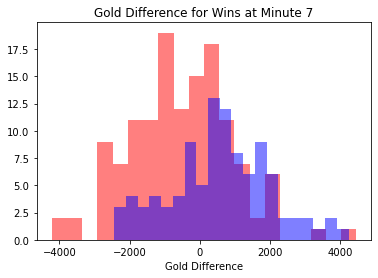

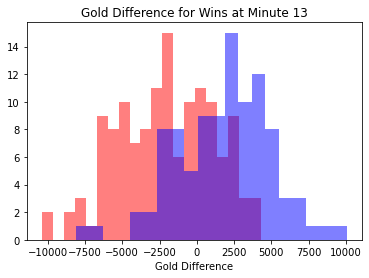

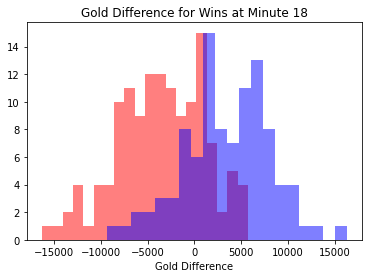

In [18]:
# Histogram of gold difference for losses at different minutes

for i in range(3):
    plt.hist(dfs[i][dfs[i]['outcome'] == 0]["gold_diff"], bins = 20, color = "red", alpha=0.5,)
    plt.hist(dfs[i][dfs[i]['outcome'] == 1]["gold_diff"], bins = 20, color = "blue", alpha=0.5,)
    plt.title(f"Gold Difference for Wins at Minute {minutes[i]}")
    plt.xlabel("Gold Difference")
    plt.show()

Right at minute 7, we can see that having a gold advantage gives you a much higher chance of winning. According to the minute 7 plot, it's rare to have a large gold lead and lose the game. Likewise, it's rather rare to be very behind in gold and win. We can also see that as the game progresses, the centers of the distributions move further and further away. For the minute 18 graph, the centers of the distributions are around 5000 and -5000 for wins and losses respectively, compared to the minute 7 graph where the distributions are around 500 and -500 respectively. This shows that at minute 18, gold differences are generally of higher magnitude, and having a gold lead at minute 18 says more about your chances of winning than they do at minute 7: if you have a gold lead above 5000 at minute 18, you're almost guaranteed to win the game. Likewise, if you have a gold disadvantage of 5000 at minute 18, it's very unlikely you'll win.


#### Gold Difference Violin Plot

Since these plots span a large range of values, perhaps this data will benefit from a continuous representation. We can also use a violin plot split by match outcome to display the data in a more visually pleasing and continuous format.

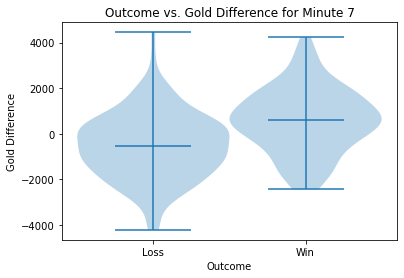

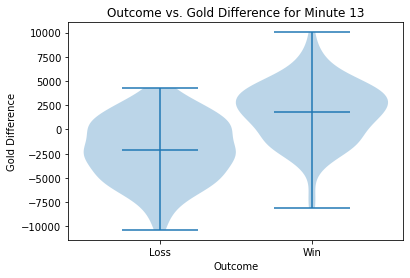

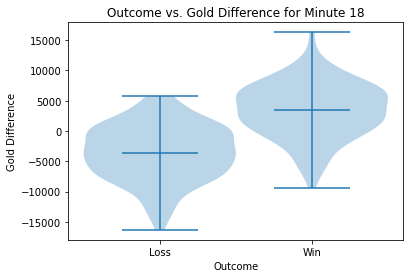

In [19]:
# Violin plot of gold difference for losses and wins

gold_violin = violin_outcome('gold_diff')

for i in range(3): 
    fig, ax = plt.subplots()
    ax.violinplot(gold_violin[i], [0, 1], widths = 1, showmeans = True) 
    ax.set_xlabel("Outcome")
    ax.set_ylabel("Gold Difference")
    ax.set_title(f"Outcome vs. Gold Difference for Minute {minutes[i]}")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Loss', 'Win'])
    

These violin plots further prove our original observation that the gold differences increase in magitude, and it becomes easier to tell who's going to win as the game progresses and the gold difference increases.

### Graphing Team Kill Difference By Game Outcome At Different Times

Next we create graphical representations of the champion kill differences between the two teams by outcome at different times. In this case we use both histograms and violin plots. 

#### Kill Difference Histogram

We represent the team kill differences by two 10-bin histograms overlaid on one another - red for loss of the current player's team, blue for victory of the current player's team.

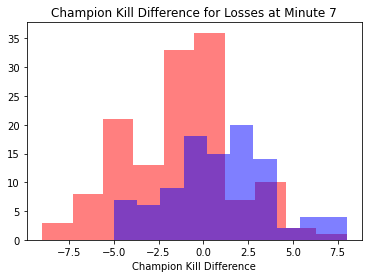

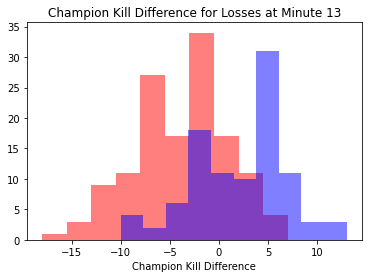

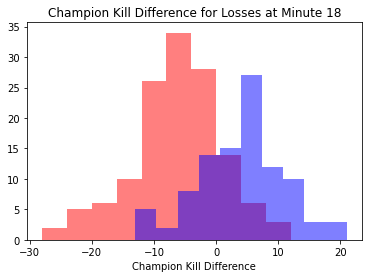

In [20]:
# Histogram of champion kill difference for losses at different minutes

for i in range(3):
    plt.hist(dfs[i][dfs[i]['outcome'] == 0]["champ_kill_diff"], bins = 10, color = "red", alpha = 0.5)
    plt.hist(dfs[i][dfs[i]['outcome'] == 1]["champ_kill_diff"], bins = 10, color = "blue", alpha = 0.5)
    plt.title(f"Champion Kill Difference for Losses at Minute {minutes[i]}")
    plt.xlabel("Champion Kill Difference")
    plt.show()


Here we can see that each histogram has a relatively normal distribution, regardless of victory or loss. Additionally, the two histograms appear to be somewhat distinct from one another, with victories tending to have positive/higher kill differences than losses. This makes sense, as that implies that when the kill difference is in favor of the player's team, they tend to win more often. On the other hand, when the kill difference is negative, meaning the enemy team has more kills, the current player's team tends to lose more often. Another interesting facet is that as time progresses, the win and loss histograms become more distinct from one another. At minute 7, it can be seen that the histograms are slightly different, but are heavily overlaid on one another. At minutes 13 and then 18 it appears that these histograms have centers that distance themselves from one another more and more. Thus it can be inferred that as time goes on, kill differences tend to follow the trend set earlier in the game. In other words, teams that got a lead in kills early seem to grow this lead further down the line, and teams that fell behind in kills seem to fall further behind.

#### Kill Difference Violin Plot

We re-represent the team kill differences using two violin plots. This allows for another perspective as to how the two outcomes are related to one another in terms of the kill difference variable.

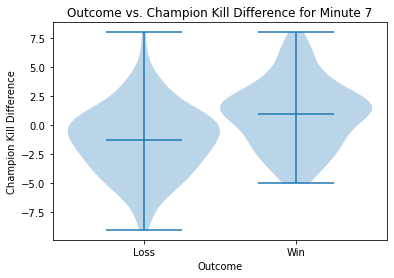

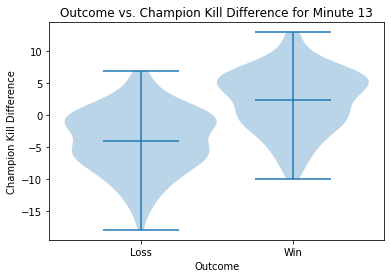

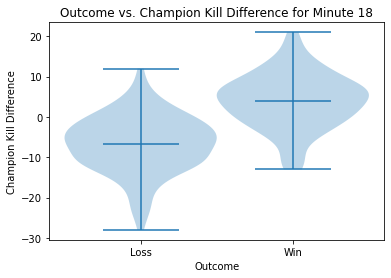

In [21]:
# Violin plot of champion kill difference for losses and wins

champ_kill_violin = violin_outcome('champ_kill_diff')

for i in range(3): 
    fig, ax = plt.subplots()
    ax.violinplot(champ_kill_violin[i], [0, 1], widths = 1, showmeans = True) 
    ax.set_xlabel("Outcome")
    ax.set_ylabel("Champion Kill Difference")
    ax.set_title(f"Outcome vs. Champion Kill Difference for Minute {minutes[i]}")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Loss', 'Win'])
    

### Tower Kill Difference Histograms

Let's take a look at the distributions of tower kills between wins and losses and as the game progresses.

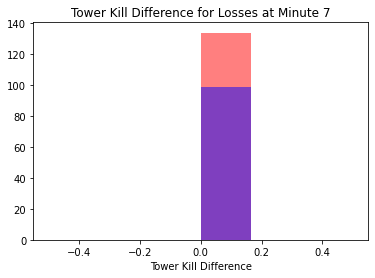

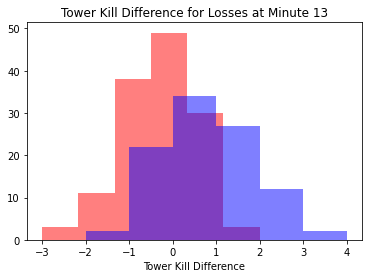

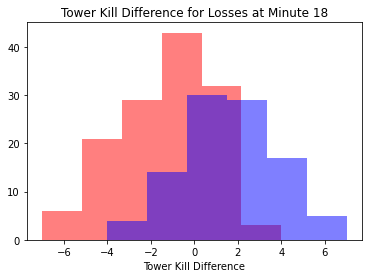

In [22]:
# Histogram of tower kill difference for losses at different minutes

for i in range(3):
    plt.hist(dfs[i][dfs[i]['outcome'] == 0]["tower_kill_diff"], bins = 6, color = "red", alpha = 0.5)
    plt.hist(dfs[i][dfs[i]['outcome'] == 1]["tower_kill_diff"], bins = 6, color = "blue", alpha = 0.5)
    plt.title(f"Tower Kill Difference for Losses at Minute {minutes[i]}")
    plt.xlabel("Tower Kill Difference")
    plt.show()
    

Interestingly, in the minute 7 histogram, we see that the tower kill differences are all 0. This shows that it's actually very rare for either team to have a tower lead at that time. Although the value would be 0 if both teams have killed the same number of towers, it's more likely that at this time neither team has killed any towers. This is because towers are extremely difficult to destroy, since there will almost always be an enemy player guarding it. As the game progresses, we see that the histograms start to take shape and separate from one another. However, it seems that tower kill differences at these times do not have as much to say about whether a team is going to win or lose, since the histograms are still overlapping a decent amount. This is because killing towers is a rather slow-paced process, so tower advantages tend to be arise later in the game (maybe if we continued to use later times such as 25 and 30 mins, we would see more of a difference).

It should be noted, however, that having a significant tower lead at 13 mins, usually 2 or more towers, it's pretty much guaranteed that the team is going to win. If a team is already getting that high of a tower lead at 13 mins, it means that the team is extremely ahead and can just further snowball their lead to a swift victory.

### Monster Kill Difference Histograms

Let's now look at the monster kill differences data. One should note that the term "monster" here encompasses all elite monsters, which are Dragons, Rift Heralds, and Barons. These monsters vary in their importance to the game: Dragons provide permanent buffs to all players of the team that slays it, while Barons provide extremely strong buffs that only last for a few minutes. For the sake of simplicity in our model, we're grouping all elite monsters into one category.

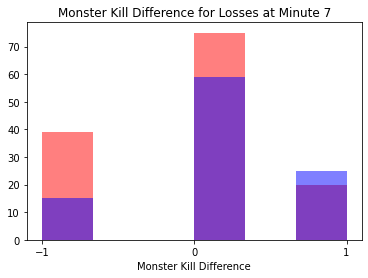

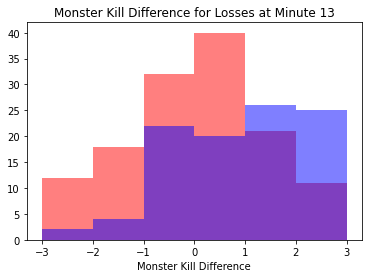

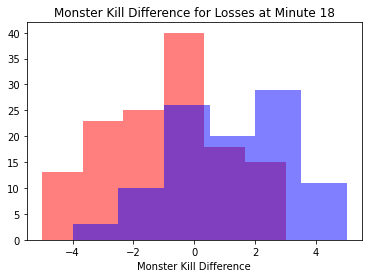

In [23]:
# Histogram of monster kill difference for losses at different minutes

for i in range(3):
    plt.hist(dfs[i][dfs[i]['outcome'] == 0]["monster_kill_diff"], bins = 6, color = "red", alpha = 0.5)
    plt.hist(dfs[i][dfs[i]['outcome'] == 1]["monster_kill_diff"], bins = 6, color = "blue", alpha = 0.5)
    plt.title(f"Monster Kill Difference for Losses at Minute {minutes[i]}")
    plt.xlabel("Monster Kill Difference")
    
    if minutes[i] == 7:
        plt.xticks([-1, 0, 1])
        
    plt.show()
    

Unlike the towers histograms at minute 7, the monster kill differences start to differ from 0 at minute 7, with the player's team sometimes having a monster kill lead of 1, or sometimes having a monster kill defecit of 1. This can be explained by the fact that monsters are much easier to kill in earlier stages of the game than towers. Although towers are protected by opposing players, monsters are unprotected and in a region of the map that is easily accessible by both teams.

These histograms appear to have even more overlap than the tower histograms. This shows that having a monster kill lead doesn't put you that much further ahead of the other team. For example, there were many games at minute 13 where the player's team had a monster kill lead of 2 to 3, but they still lost. This could be a result of the team killing many Rift Heralds, which is a less impactful monster but killing it still adds one to the total number of monster kills. This shows that it may be beneficial to differentiate between the different monster types, however in order to maintain simplicity we won't be doing that in this tutorial.

### Graphing Level Difference By Game Outcome At Different Times

Once again, we generate the same type of histogram as earlier but for average team level differences. This means we create a graphical representation of how many wins and losses had a certain average level difference between the two teams at our time intervals, with wins in blue and losses in red.

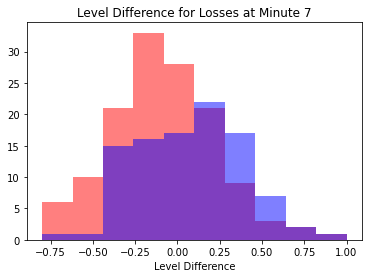

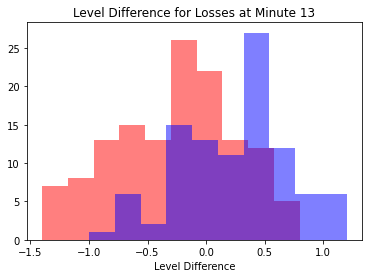

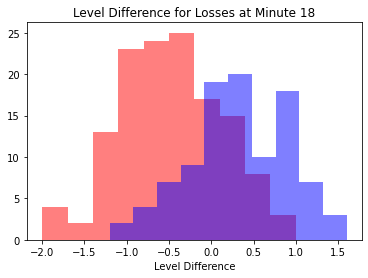

In [24]:
# Histogram of level difference for losses at different minutes

for i in range(3):
    plt.hist(dfs[i][dfs[i]['outcome'] == 0]["level_diff"], bins = 10, color = "red", alpha = 0.5)
    plt.hist(dfs[i][dfs[i]['outcome'] == 1]["level_diff"], bins = 10, color = "blue", alpha = 0.5)
    plt.title(f"Level Difference for Losses at Minute {minutes[i]}")
    plt.xlabel("Level Difference")
    plt.show()
    

Here we can see that the histograms are very roughly normal, but are still somewhat uneven. It does somewhat follow the same trend as the previous two variables, as the centers of the level difference histograms seem to slowly drift further from one another as we look at later times. However, the change is much less drastic. There is still a clear indication that the histogram representing wins generally has a positive level difference, even from minute 7. This makes sense, as leveling up tends to give a larger relative boost to stats earlier in the game, when all the champions are weaker, as opposed to leveling up later in the game, when many champions are already higher level and have items to boost their stats. As a result, though the level difference is an important indicator of how a team is performing, the average level difference generally won't be too great, even as teams solidify their lead later in the game. This somewhat explains why the centers of the histograms don't grow further and further apart, as they do in the histogram representations of previous variables.

## Predicting the Outcome

We've confirmed that the data we collected is useful in helping to predict the outcome of matches. Now let's try to train some models to see how accurately we can predict outcomes. The models we'll be using are linear regression, logistic regression, decision tree classifier, and random forest classifier. 


In [25]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier

lin_reg_pred = []
lin_reg_actual = []
acc_list = []
acc_list.append(['Linear Regression', 'Decision Tree', 'Logistic Regression', 'Random Forest'])

mod_df = pd.DataFrame(columns = ['Minute 7', 'Minute 13', 'Minute 18'])

# Calculate model accuracies for each time stamp
for i in range(3):
    fields_x = dfs[i][["gold_diff", "level_diff", "monster_kill_diff", "tower_kill_diff", "champ_kill_diff"]]
    outcome_y = dfs[i][["outcome"]]
    min_acc_list = []
    
    # Splitting data for hold-out validation
    X, y = fields_x, outcome_y
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)
    
    # Linear regression
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    y_pred_lin = lin_reg.predict(X_test)
    rounded_y_pred_lin = [round(x[0]) for x in y_pred_lin]
    lin_reg_pred.append([x[0] for x in y_pred_lin])
    lin_reg_actual.append(y_test['outcome'])
    min_acc_list.append(metrics.accuracy_score(y_test, rounded_y_pred_lin))
    
    # Decision Tree
    clf_dt = DecisionTreeClassifier(random_state=12)
    clf_dt.fit(X_train, y_train)
    y_pred_dt = clf_dt.predict(X_test)
    min_acc_list.append(metrics.accuracy_score(y_test, y_pred_dt))
    
    # Logistic Regression
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train.values.ravel())
    y_pred_log_reg = log_reg.predict(X_test)
    min_acc_list.append(metrics.accuracy_score(y_test, y_pred_log_reg))
    
    # Random Forest
    clf_rf = RandomForestClassifier(n_estimators=100, random_state=12)
    clf_rf.fit(X_train, y_train.values.ravel())
    y_pred_rt = clf_rf.predict(X_test)
    min_acc_list.append(metrics.accuracy_score(y_test, y_pred_rt))
    
    acc_list.append(min_acc_list)

In [26]:
# Display model accuracies at each time in a DataFrame

mod_df_col = ['Model', 'Minute 7', 'Minute 13', 'Minute 18']
mod_df = pd.DataFrame(columns = mod_df_col)

for i in range(4):
    mod_df[mod_df_col[i]] = acc_list[i]

mod_df.style.hide_index()

Model,Minute 7,Minute 13,Minute 18
Linear Regression,0.657143,0.671429,0.757143
Decision Tree,0.614286,0.671429,0.657143
Logistic Regression,0.671429,0.671429,0.757143
Random Forest,0.600000,0.714286,0.771429


Here we have the results of our four machine learning models in terms of their prediction success rates through holdout validation. Looking across the board, it seems that there's a general trend of increasing accuracy of the model for later stages of the game. Looking at the individual models themselves, it turns out that we have varying levels of success between all four of them. For linear regression and logistic regression models, it appears that they are the most well-rounded, with relatively higher success rates from minutes 7 to 13 to 18. On the other hand, it appears that the decision tree model tends to have the same or worse performance compared to the other models across the 3 stages of the game. The random forest model appears to perform poorly for minute 7, the earliest stage of the game, but turns out to be the most accurate for the middle and later stages of the game at minutes 13 and 18. Thus these models may be interchangeably used based on the situation and stage of the game, using the linear or logistic regression models for the earlier game and the random forest model for the middle and later stages of the game.

An important point worth noting is that these prediction accuracies are not particularly high. While they are a decent amount above the expected 50%, they all sit around the 65-75% range. This could be attributed to a great number of things. First of all, LoL games generally tend to run anywhere from 20 to 50 minutes on average. However, we only analyze up to 18 minutes. This leaves a large amount of time that we don't have data for, in which a large amount of change can happen during the game.

For example, as you might recall, LoL has a huge number of champions with very different playstyles. Some of these champions are much more 'early-game' oriented, meaning they're relatively stronger during the early stages of the game but get relatively less impactful later in the game, versus 'late-game' or 'scaling' champions, which are relatively weak in the earlier stages, but get stronger and stronger as the game progresses. Since our model is incapable of differentiating these attributes in champions, this can create a good amount of bias. A team might appear to be doing poorly to our model, but may really have several 'late-game' champions that will dominate in the later stages. On the other hand, a team that might appear to have a strong lead to our model may just have more early-game champions, which will fall off and lose impact as the game progresses further.

Additionally, we take elite monster kills into account. Elite monsters are monsters on the map that can be killed by either team for a team buff which is generally very powerful. However, one important detail is that these buffs are not equal. Killing a standard elemental dragon, for example, will give your entire team a small buff to some stats. However, killing an elder dragon will provide a huge team-wide boost to combat power. Additionally, killing the Baron Nashor will provide a team-wide boost to stats in addition to empowering all friendly minions, which is a very powerful ability. In other words, some elite monsters provide stronger buffs than others, which is not taken into account here. It's possible for a weaker team to slay a powerful elite monster and gain an upper hand, turning the tides of the game in the later stages.

Ultimately, LoL game outcomes may follow a general trend in terms of gold and levels, but still have a vast amount of unpredictability. Due to the numerous moving parts of a game such as champion style, team coordination, human judgement, etc., it's unsurprising that our model does not have outstanding success.

## Conclusion

Even though our accuracy of our prediction algorithms were on the lower side, we expected this due to the unpredictable nature of the game. Nevertheless, there are countless other features we could have included to improve the accuracies of our models. For example, we could have looked at the historical stats of the match participants: if some players have a history of exceling in the later stages of the game, we could have incorporated that into our models, which may predict a win for those players even if they're falling a little behind in the early stages of the game. Other in-game variables could have been collected as well, which also have the potential to improve the model.

Through our analysis, we discovered that as the game progresses, it gets much easier to predict who will win the game. This shows that if a team is extremely behind late in the game, they have a very low chance of winning, as all the odds are against them. It's rare for a team to emerge victorious from a position like that. Nevertheless, these miracle games do happen, whether its the enemy team making a grave mistake which causes them to throw away their lead, or the allied team making countless good decisions, slowly catching the team up and bringing them to a tight but absolute victory.

League of Legends is a complicated game, with many moving parts and even more unpredictable outcomes. Although some in-game variables may help to indicate which team will ultimately win, it will always be impossible to know for certain the team that will emerge as the victor.